Scene[
  children = [
    PathIntegrator[
      max_depth = 3,
      rr_depth = 5
    ],
    PerspectiveCamera[
      x_fov = [35],
      near_clip = 0.01,
      far_clip = 10000,
      film = HDRFilm[
        size = [1280, 720],
        crop_size = [1280, 720],
        crop_offset = [0, 0],
        sample_border = 0,
        compensate = 0,
        filter = TentFilter[radius=1.000000],
        file_format = OpenEXR,
        pixel_format = rgb,
        component_format = float16,
      ],
      sampler = IndependentSampler[
        base_seed = 0
        sample_count = 64
        samples_per_wavefront = 1
        wavefront_size = 0
      ],
      resolution = [1280, 720],
      shutter_open = 0,
      shutter_open_time = 0,
      to_world = [[-4.37113e-08, 0, -1, 28.2792],
                  [0, 1, 0, 3.5],
                  [1, 0, -4.37113e-08, 1.23612e-06],
                  [0, 0, 0, 1]]
    ],
    TwoSided[
      brdf[0] = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[

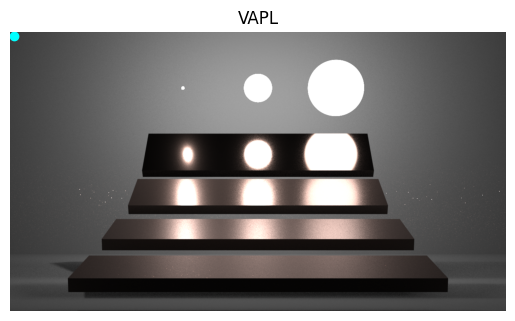

Scene[
  children = [
    PathIntegrator[
      max_depth = 3,
      rr_depth = 5
    ],
    PerspectiveCamera[
      x_fov = [35],
      near_clip = 0.01,
      far_clip = 10000,
      film = HDRFilm[
        size = [1280, 720],
        crop_size = [1280, 720],
        crop_offset = [0, 0],
        sample_border = 0,
        compensate = 0,
        filter = TentFilter[radius=1.000000],
        file_format = OpenEXR,
        pixel_format = rgb,
        component_format = float16,
      ],
      sampler = IndependentSampler[
        base_seed = 0
        sample_count = 64
        samples_per_wavefront = 1
        wavefront_size = 0
      ],
      resolution = [1280, 720],
      shutter_open = 0,
      shutter_open_time = 0,
      to_world = [[-4.37113e-08, 0, -1, 28.2792],
                  [0, 1, 0, 3.5],
                  [1, 0, -4.37113e-08, 1.23612e-06],
                  [0, 0, 0, 1]]
    ],
    TwoSided[
      brdf[0] = SmoothDiffuse[
        reflectance = SRGBReflectanceSpectrum[

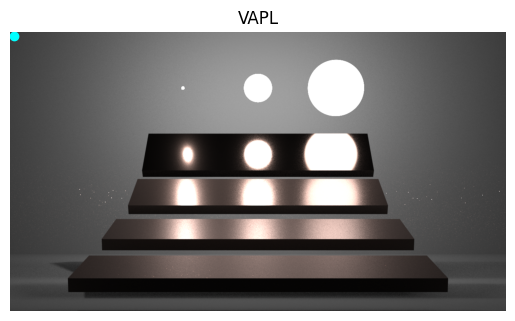

In [1]:
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")

import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import importlib

import testing_scene as ts
importlib.reload(ts)

import vapl_utils as utils
importlib.reload(utils)

import torch

# TODO: add visualization graph
# from torchviz import make_dot
# import torchvision
# from torchview import draw_graph


In [ ]:
def plot_vapl_means(scene, pos, variance, amplitude, axis, h, w, ax):
    """Render the 'mean' positions of the Virtual Anisotropic Point Lights (VAPL) on the image.

    Args:
        scene (mi.Scene): Mitsuba scene.
        vapl_model (vapl_grid): The trained VAPL grid model.
        image (np.ndarray): The image to plot the points on.
        h (int): Height of the image in pixels.
        w (int): Width of the image in pixels.
        ax (matplotlib.axes.Axes): Matplotlib axis object for plotting.
    """
    p = pos.cpu().detach().numpy()
    variance = variance.cpu().detach().numpy().flatten()
    amplitude = amplitude.cpu().detach().numpy()
    # Convert the mean positions from world coordinates to NDC
    means_ndc = utils.world_to_ndc(scene, p)  # Convert from Torch tensor to numpy array

    # Convert NDC to pixel coordinates
    means_pix = utils.ndc_to_pixel(means_ndc, h, w)

    amplitude_norm = amplitude / amplitude.max() if amplitude.max() > 0 else amplitude
    colors = amplitude_norm

    point_sizes = 10 * variance

    axis_nds = utils.world_to_ndc(scene, axis.cpu().detach().numpy())
    axis_pix = utils.ndc_to_pixel(axis_nds, h, w)

    dx = axis_pix.x - means_pix.x
    dy = axis_pix.y - means_pix.y

    ax.scatter(means_pix.x, means_pix.y, c=colors, marker='o', s=point_sizes)
    ax.quiver(means_pix.x, means_pix.y, dx, dy, angles='uv', color=colors, scale=1, scale_units='xy')


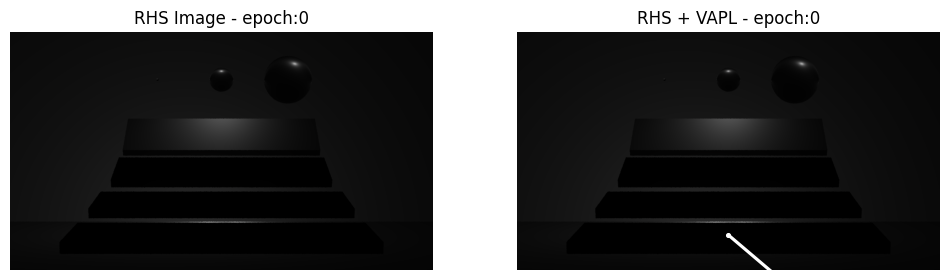

In [ ]:
loss_function = utils.Loss(utils.weighted_loss)
field = utils.vapl_grid(ts.scene.bbox().min, ts.scene.bbox().max, 3, 4, 8).cuda()
rhs_integrator = utils.RHSIntegrator(field, loss_function)

def should_render(epoch):
    if epoch < 50:
        return epoch % 5 == 0
    elif epoch < 500:
        return epoch % 20 == 0
    elif epoch < 2000:
        return epoch % 100 == 0
    else:
        return epoch % 250 == 0

for epoch in range(10001):
    rhs_integrator.epoch = epoch

    rhs_image = mi.render(ts.scene, spp=1, integrator=rhs_integrator)

    if (should_render(epoch)):
        with torch.no_grad():
            gaussians, vmfs = utils.get_all_gaussians(field)

            mean = gaussians[:, :3]
            utils.print_tensor_stats(mean, "positions")
            variance = gaussians[:, 3]
            amplitude = vmfs[:, 4:7]
            axis = vmfs[:, 1:4]

            h, w = rhs_image.shape[0], rhs_image.shape[1]

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))

            ax[0].imshow(np.clip(rhs_image ** (1.0 / 2.2), 0, 1))
            ax[0].axis("off")
            ax[0].set_title(f"RHS Image - epoch:{epoch}")

            plot_vapl_means(ts.scene, mean, variance, amplitude,axis, h, w, ax[1])
            ax[1].imshow(np.clip(rhs_image ** (1.0 / 2.2), 0, 1))
            ax[1].axis("off")
            ax[1].set_title(f"RHS + VAPL - epoch:{epoch}")

            plt.show()